# Basic Analysis of Breast Cancer Statistics in Mimic-III Database

### Overview

In this exercise, we will perform some basic analysis of breast cancer patient data in the MIMIC-III Database.

### Initialization

For this analysis, we'll be using `pandas` for data loading and dataframe manipulation; `matplotlib` for visualizations; and `warnings` to suppress an ugly, unavoidable warning that a `pandas`/`numpy` bug throws.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings 

# all data has been de-identified.

# ignore global numpy warnings that are thrown by pandas
warnings.simplefilter(action='ignore', category=FutureWarning)





### Data

We'll be using five data files from the MIMIC-III database to load diagnoses, procedures, patient data, prescription data, and ICD9 code data. We're specifying specific `usecols` values for our prescriptions because there are data type inconsistencies in other (unused) columns that generate warnings.

Once we've loaded our data files, we'll take a quick look at each dataframe so we know what we're dealing with.

In [2]:
diagDF = pd.read_csv("/home/cs52700/mimiciii/DIAGNOSES_ICD.csv", index_col=0)
admitDF = pd.read_csv("/home/cs52700/mimiciii/ADMISSIONS.csv", usecols=['ROW_ID', 'HADM_ID', 'ADMITTIME'], index_col=0)
procDF = pd.read_csv("/home/cs52700/mimiciii/PROCEDURES_ICD.csv", index_col=0)
patDF  = pd.read_csv("/home/cs52700/mimiciii/PATIENTS.csv", index_col=0)
diagCodeDF = pd.read_csv("/home/cs52700/mimiciii/D_ICD_DIAGNOSES.csv", index_col=0)
procCodeDF = pd.read_csv("/home/cs52700/mimiciii/D_ICD_PROCEDURES.csv", index_col=0)
scripDF = pd.read_csv("/home/cs52700/mimiciii/PRESCRIPTIONS.csv", usecols=['ROW_ID', 'SUBJECT_ID', 'DRUG'], index_col=0)


Note that here we are paring down our patient data to only include patients with ICD9 codes that match breast cancer. We also want to merge this with our admissions data so we can associate dates with each diagnosis.

In [3]:
bcDF = diagDF[diagDF['ICD9_CODE'].isin(["1749", "1759", "19881", "V103"])]

bcDF = pd.merge(bcDF, admitDF, on='HADM_ID')

bcDF['ADMITTIME'] = bcDF['ADMITTIME'].astype('datetime64[ns]')

bcDF.head()


,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME
0,127,141647,3.0,V103,2183-08-20 17:25:00
1,298,119446,7.0,V103,2140-08-07 00:33:00
2,298,119686,5.0,V103,2140-09-29 12:55:00
3,394,139612,7.0,V103,2180-09-21 20:28:00
4,394,140561,9.0,V103,2181-07-15 18:23:00


In [4]:
procDF['ICD9_CODE'] = procDF['ICD9_CODE'].astype('str')
procDF.head()


,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
ROW_ID,,,,
944,62641,154460,3,3404
945,2592,130856,1,9671
946,2592,130856,2,3893
947,55357,119355,1,9672
948,55357,119355,2,331


In [5]:
procCodeDF['ICD9_CODE'] = procCodeDF['ICD9_CODE'].astype('str')
procCodeDF.head()


,ICD9_CODE,SHORT_TITLE,LONG_TITLE
ROW_ID,,,
264,851,Canthotomy,Canthotomy
265,852,Blepharorrhaphy,Blepharorrhaphy
266,859,Adjust lid position NEC,Other adjustment of lid position
267,861,Lid reconst w skin graft,Reconstruction of eyelid with skin flap or graft
268,862,Lid reconst w muc graft,Reconstruction of eyelid with mucous membrane ...


In [6]:
patDF['DOB'] = patDF['DOB'].astype('datetime64[ns]')

patDF.head()

,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
ROW_ID,,,,,,,
234,249,F,2075-03-13,NaN,NaN,NaN,0
235,250,F,2164-12-27,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
236,251,M,2090-03-15,NaN,NaN,NaN,0
237,252,M,2078-03-06,NaN,NaN,NaN,0
238,253,F,2089-11-26,NaN,NaN,NaN,0


In [7]:
scripDF = scripDF[['SUBJECT_ID', 'DRUG']]
scripDF.head()

,SUBJECT_ID,DRUG
ROW_ID,,
2214776,6,Tacrolimus
2214775,6,Warfarin
2215524,6,Heparin Sodium
2216265,6,D5W
2214773,6,Furosemide


Once we've loaded and prepared our data, we can merge our breast cancer diagnosis records with our patient data. This allows us to associate our anonymized patient DOB (year of birth) with our diagnoses.

There's some gloriously ugly data transformation going on here. Here's what we're doing:

1. Calculate a timedelta value based on admit time minus date of birth
1. Convert this value directly to a string. This will give us a timedelta in the format 'xxxxx days, yyyyyyy'
1. Split this string on the first space that appears. This will give us the total number of days only.
1. convert this value once more, this time to a float
1. Divide this float by 365.25 (taking leap year into account!)
1. Finally, convert this float to an int. This conversion automatically rounds down, which is exactly the behavior we want.

When it's all said and done, we end up with the patient's age at time of hospital admission! It's an ugly kludge, sure, but it *works*, and I'm fine with that.

In [8]:
mergeDF = pd.merge(bcDF, patDF, on='SUBJECT_ID')
mergeDF['EVENT_AGE'] = mergeDF['ADMITTIME'] - mergeDF['DOB']
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'].astype('str')
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'].str.split(" ", 1, expand=True)
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'].astype('float')
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'] / 365.25
mergeDF['EVENT_AGE'] = mergeDF['EVENT_AGE'].astype('int')


mergeDF.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ADMITTIME,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,EVENT_AGE
0,127,141647,3.0,V103,2183-08-20 17:25:00,F,2135-02-01,2184-02-22 00:00:00,NaN,2184-02-22 00:00:00,1,48
1,298,119446,7.0,V103,2140-08-07 00:33:00,F,2067-09-14,NaN,NaN,NaN,0,72
2,298,119686,5.0,V103,2140-09-29 12:55:00,F,2067-09-14,NaN,NaN,NaN,0,73
3,394,139612,7.0,V103,2180-09-21 20:28:00,F,2101-09-27,2187-03-18 00:00:00,NaN,2187-03-18 00:00:00,1,78
4,394,140561,9.0,V103,2181-07-15 18:23:00,F,2101-09-27,2187-03-18 00:00:00,NaN,2187-03-18 00:00:00,1,79


Now, we can drop duplicates and group our patients by minimum event age, then by year-of-birth, counting the total number of unique patient IDs at the end. Then, we'll draw a histogram of this data.

In [9]:
ageDF = mergeDF[['SUBJECT_ID', 'EVENT_AGE']]
ageDF = ageDF.drop_duplicates()
ageDF = ageDF.groupby(['SUBJECT_ID'], as_index=False).min()
ageDF = ageDF.groupby(['EVENT_AGE'], as_index=False).count()

ageDF.head()

,EVENT_AGE,SUBJECT_ID
0,-284,105
1,-283,1
2,-282,2
3,-281,1
4,-280,2


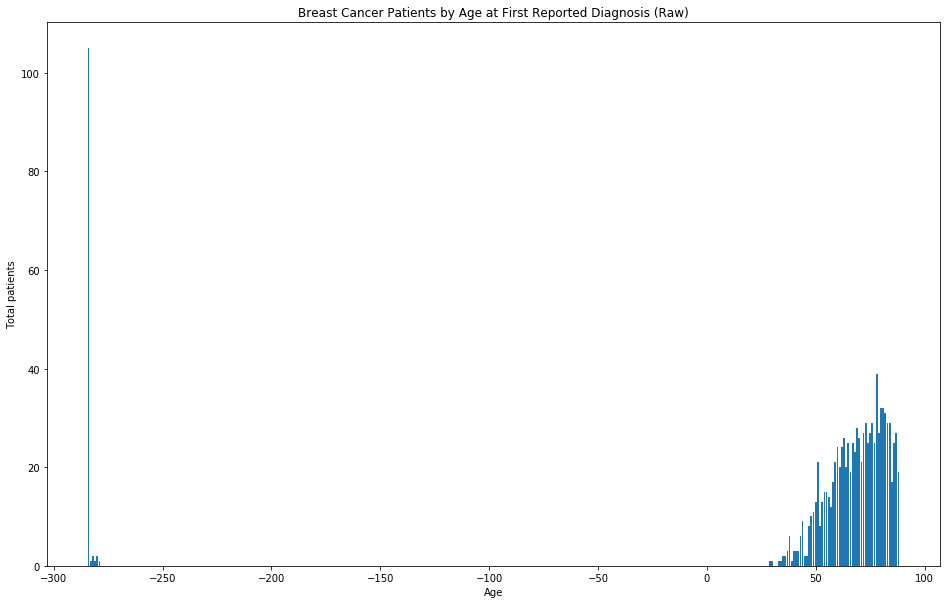

In [18]:
plt.title("Breast Cancer Patients by Age at First Reported Diagnosis (Raw)")
plt.xlabel("Age")
plt.ylabel("Total patients")
plt.bar(ageDF['EVENT_AGE'], ageDF['SUBJECT_ID'])
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

# Jupyter bug: you need to manually re-run this plot after running the full notebook to make it the right size.
# Sorry.

Looking at our histogram, it becomes immediately evident that there are some inconsistent entries. For example, we have impressive numbers of breast cancer patients who were first diagnosed nearly 300 years before they were born. While medical science may some day be able to provide our descendants with such astonishingly foresighted diagnoses, we know for a fact that 17th century medical science decidedly could **not** achieve this amazing feat.

Let's eliminate this bad data.

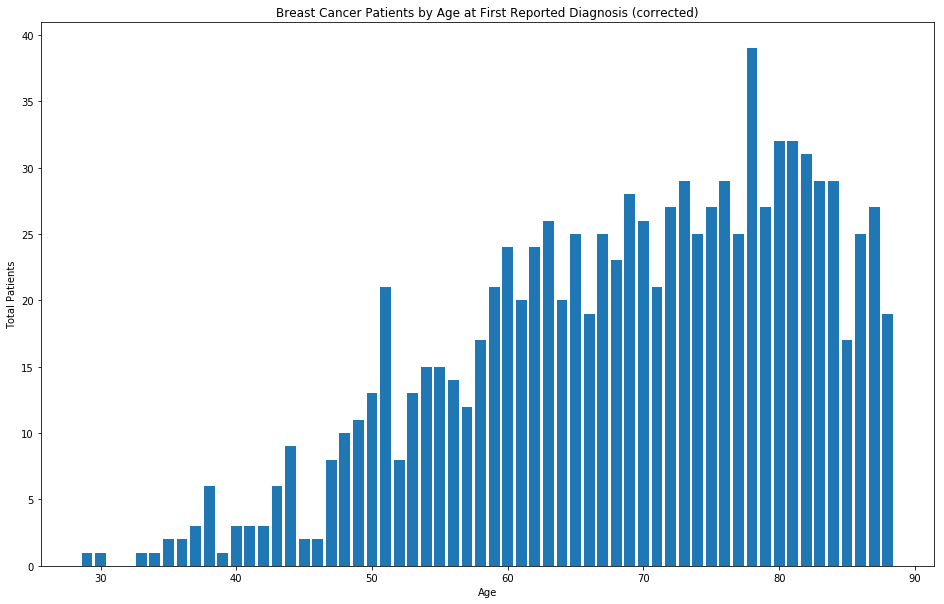

In [11]:
corAgeDF = ageDF[ageDF['EVENT_AGE'] > 0];

corAgeDF.head()

plt.title("Breast Cancer Patients by Age at First Reported Diagnosis (corrected)")
plt.xlabel("Age")
plt.ylabel("Total Patients")
plt.bar(corAgeDF['EVENT_AGE'], corAgeDF['SUBJECT_ID'])
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

...and there we have it: breast cancer incidence rates graphed by age of a patient's first reported breast cancer ICD9 code!

Let's do a few more. Let's look at associated conditions, too!

In [12]:
bcPatientsDF = mergeDF[['SUBJECT_ID']]
bcPatientsDF = bcPatientsDF.drop_duplicates()

bcConditionsDF = pd.merge(bcPatientsDF, diagDF, on='SUBJECT_ID')
bcConditionsDF = bcConditionsDF[['ICD9_CODE', 'SUBJECT_ID']]


bcConditionsDF = bcConditionsDF[~bcConditionsDF['ICD9_CODE'].isin(["1749", "1759", "19881", "V103"])]
bcConditionsDF = bcConditionsDF.groupby(['ICD9_CODE'], as_index=False).count()
bcConditionsDF = bcConditionsDF.sort_values(by=['SUBJECT_ID'], ascending=False)
bcConditionsDF = bcConditionsDF.head(10)

bcConditionDefinitionsDF = pd.merge(bcConditionsDF, diagCodeDF, on='ICD9_CODE')
bcConditionDefinitionsDF = bcConditionDefinitionsDF.rename(columns={"SUBJECT_ID": "PATIENT_COUNT"})
bcConditionDefinitionsDF


,ICD9_CODE,PATIENT_COUNT,SHORT_TITLE,LONG_TITLE
0,4019,709,Hypertension NOS,Unspecified essential hypertension
1,42731,462,Atrial fibrillation,Atrial fibrillation
2,4280,459,CHF NOS,"Congestive heart failure, unspecified"
3,41401,314,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
4,2449,283,Hypothyroidism NOS,Unspecified acquired hypothyroidism
5,5990,281,Urin tract infection NOS,"Urinary tract infection, site not specified"
6,25000,273,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...
7,5849,272,Acute kidney failure NOS,"Acute kidney failure, unspecified"
8,2724,267,Hyperlipidemia NEC/NOS,Other and unspecified hyperlipidemia
9,51881,263,Acute respiratry failure,Acute respiratory failure


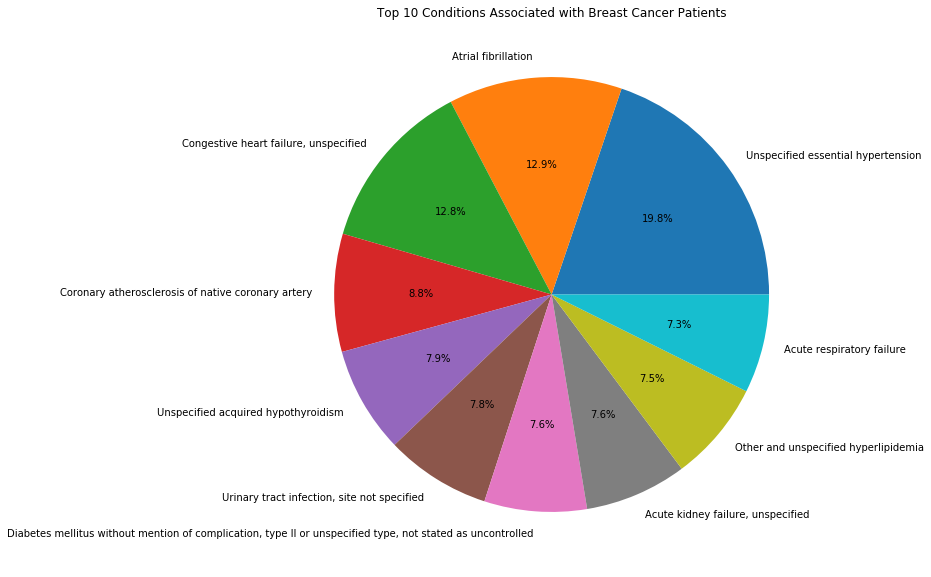

In [13]:

plt.title("Top 10 Conditions Associated with Breast Cancer Patients")
plt.pie(bcConditionDefinitionsDF['PATIENT_COUNT'], labels=bcConditionDefinitionsDF['LONG_TITLE'], autopct='%1.1f%%')
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

Next up: associated procedures!

In [14]:

bcProceduresDF = pd.merge(bcPatientsDF, procDF, on='SUBJECT_ID')
bcProceduresDF = bcProceduresDF[['ICD9_CODE', 'SUBJECT_ID']]


bcProceduresDF = bcProceduresDF[~bcProceduresDF['ICD9_CODE'].isin(["1749", "1759", "19881", "V103"])]
bcProceduresDF = bcProceduresDF.groupby(['ICD9_CODE'], as_index=False).count()
bcProceduresDF = bcProceduresDF.sort_values(by=['SUBJECT_ID'], ascending=False)
bcProceduresDF = bcProceduresDF.head(10)


bcProceduresDF = pd.merge(bcProceduresDF, procCodeDF, on='ICD9_CODE')
bcProceduresDF = bcProceduresDF.rename(columns={"SUBJECT_ID": "PATIENT_COUNT"})
bcProceduresDF.head(10)

,ICD9_CODE,PATIENT_COUNT,SHORT_TITLE,LONG_TITLE
0,3893,433,Venous cath NEC,"Venous catheterization, not elsewhere classified"
1,9604,244,Insert endotracheal tube,Insertion of endotracheal tube
2,9671,232,Cont inv mec ven <96 hrs,Continuous invasive mechanical ventilation for...
3,9904,206,Packed cell transfusion,Transfusion of packed cells
4,966,197,Entral infus nutrit sub,Enteral infusion of concentrated nutritional s...
5,9672,141,Cont inv mec ven 96+ hrs,Continuous invasive mechanical ventilation for...
6,3891,125,Arterial catheterization,Arterial catheterization
7,8856,125,Coronar arteriogr-2 cath,Coronary arteriography using two catheters
8,3961,114,Extracorporeal circulat,Extracorporeal circulation auxiliary to open h...
9,3324,96,Closed bronchial biopsy,Closed [endoscopic] biopsy of bronchus


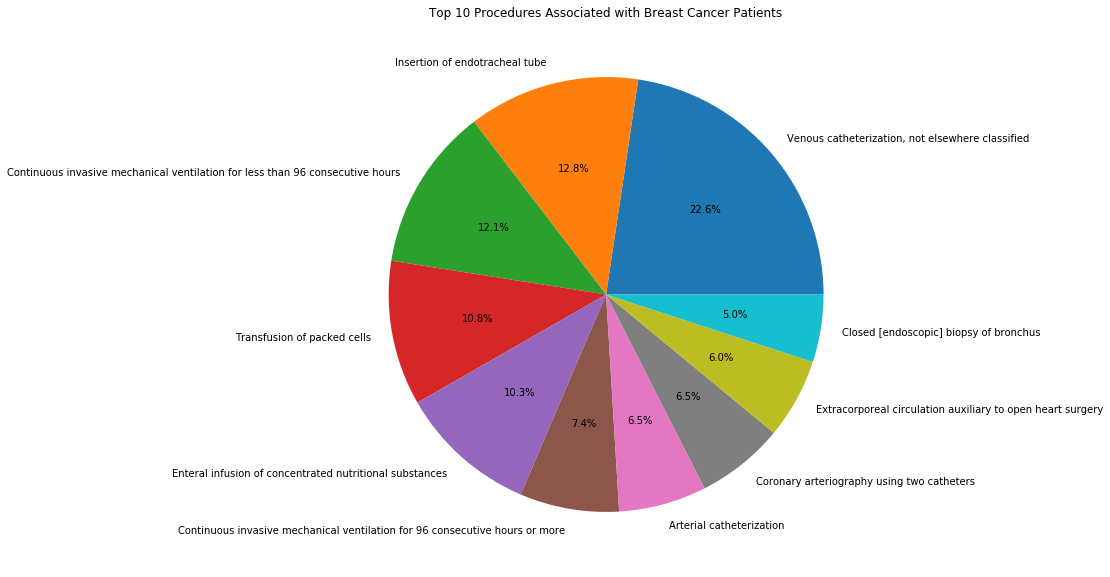

In [15]:

plt.title("Top 10 Procedures Associated with Breast Cancer Patients")
plt.pie(bcProceduresDF['PATIENT_COUNT'], labels=bcProceduresDF['LONG_TITLE'], autopct='%1.1f%%')
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

...and finally, associated drug prescriptions!

In [16]:

bcDrugsDF = pd.merge(bcPatientsDF, scripDF, on='SUBJECT_ID')
bcDrugsDF = bcDrugsDF[['SUBJECT_ID', 'DRUG']]


bcDrugsDF = bcDrugsDF.groupby(['DRUG'], as_index=False).count()
bcDrugsDF = bcDrugsDF.sort_values(by=['SUBJECT_ID'], ascending=False)
bcDrugsDF = bcDrugsDF.head(10)


bcDrugsDF = bcDrugsDF.rename(columns={"SUBJECT_ID": "PATIENT_COUNT"})
bcDrugsDF.head(10)

,DRUG,PATIENT_COUNT
936,Potassium Chloride,5658
457,Furosemide,4270
9,0.9% Sodium Chloride,4233
782,NS,3646
565,Insulin,3491
292,D5W,3274
674,Magnesium Sulfate,2663
1043,Sodium Chloride 0.9% Flush,2626
578,Iso-Osmotic Dextrose,2416
14,5% Dextrose,2238


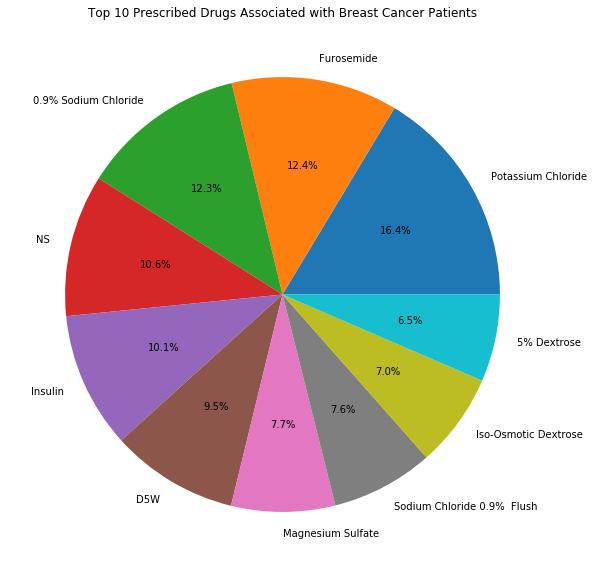

In [17]:

plt.title("Top 10 Prescribed Drugs Associated with Breast Cancer Patients")
plt.pie(bcDrugsDF['PATIENT_COUNT'], labels=bcDrugsDF['DRUG'], autopct='%1.1f%%')
plt.rcParams['figure.figsize'] = [16, 10]
plt.show()

...so these last few results aren't specifically related to breast cancer, with the possible ecxeption of Furosemide, which is used to relieve edema, a common condition after lymph node removal. That said, it's still an interesting result to look at. Future work might narrow these last few graphs down so that instead of looking at the patient as a whole across their entire admission history, we examine only the specific admissions where breast cancer is an indicated ICD9 code. That might look a bit more interesting.